In [1]:
import pandas as pd
import pybasilica.run as run

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_path = "/Users/elenab/Library/CloudStorage/GoogleDrive-ele.buscaroli@gmail.com/My Drive/work/signatures/data_sigphylo.csv"
m = pd.read_csv(m_path)
ref_path = "/Users/elenab/GitHub/pybasilicah/pybasilica/data/cosmic/cosmic_catalogue.csv"
cosmic = pd.read_csv(ref_path, index_col=0)


In [3]:
m 

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,11,10,4,14,19,5,4,5,54,24,...,2,17,10,3,10,20,6,3,4,8
1,7,6,1,10,6,4,1,2,9,5,...,0,9,4,3,4,9,2,2,2,7
2,357,16,1,23,14,5,1,10,14,4,...,17,20,4,3,3,12,4,1,2,6
3,402,27,3,44,12,1,2,16,17,4,...,5,11,6,7,2,7,3,0,4,7
4,20,10,2,10,2,1,5,2,12,7,...,10,25,9,4,3,10,2,3,7,7


In [ ]:
# import torch
# sig1 = torch.tensor(cosmic.values)[0]
# sig2 = torch.tensor(cosmic.values)[29]

# sig1[sig1==0] = 1e-7
# # print(torch.log(sig1))
# sig2[sig2==0] = 1e-7
# # print(torch.log(sig2))
# torch.nn.functional.kl_div(torch.log(sig1), torch.log(sig2), log_target=True, reduction="batchmean")


In [4]:
m.shape

(5, 96)

In [18]:
one = run.fit(
    x=m, 
    k_list=[1,2], 
    lr=0.05, 
    n_steps=500, 
    enumer="parallel", 
    cluster=None, 
    # groups=[0,1,1,0,1], 
    beta_fixed=cosmic.iloc[:2,:], 
    hyperparameters={"alpha_var":10000},
    compile_model = False, 
    CUDA = False, 
    enforce_sparsity = False, 
    regularizer = "cosine", 
    reg_weight = 1., 
    reg_bic = True, 
    store_parameters=False, 
    verbose = False, 
    stage = "random_noise", 
    save_runs_seed=True,
    seed=[1,5,17],
    initializ_pars_fit = True,
    initializ_seed = False,
    new_hier=True
    )

# 5 = n_samples, 1,2 + 2 = n_sigs, 2 = n_groups

Running with seed 1

Running with seed 5

Running with seed 17

Running with seed 1

Running with seed 5

Running with seed 17



In [19]:
obj = one[0]

In [20]:
obj.groups 

[0, 0, 0, 0, 0]

In [24]:
obj.alpha

,SBS1,SBS2,D1,D2
0,0.286269,0.093143,0.089573,0.531015
1,0.313627,0.128853,0.150125,0.407396
2,0.087582,0.082358,0.727499,0.102560
3,0.084396,0.079610,0.746036,0.089957
4,0.213773,0.104424,0.184651,0.497152


In [48]:
obj.hyperparameters 

{'alpha_var': 10000,
 'alpha_prior_var': 1,
 'exp_rate': 10,
 'beta_var': 1,
 'eps_var': 10}

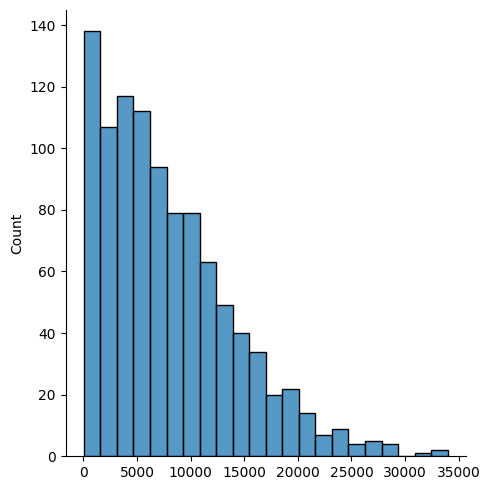

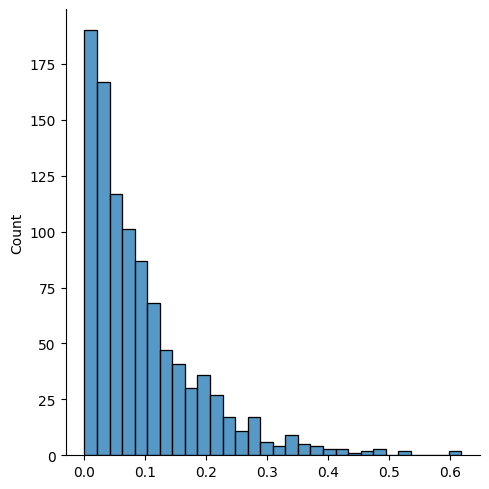

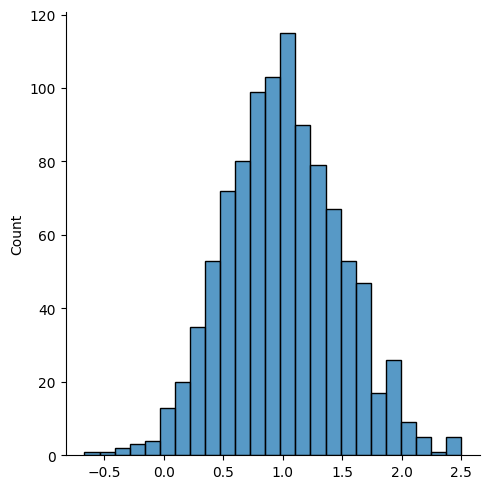

In [49]:
from pyro import distributions as distr
import seaborn as sns

sns.displot(distr.HalfNormal(obj.hyperparameters["alpha_var"]).sample_n(1000).tolist())
sns.displot(distr.Exponential(obj.hyperparameters["exp_rate"]).sample_n(1000).tolist()) 
sns.displot(distr.Normal(1, 0.5).sample_n(1000).tolist())

In [ ]:
x2 = one.epsilon.astype(int)

In [ ]:
two = run.fit(
    x=x2, 
    k_list=[1,2,3,4,5], 
    lr=0.05, 
    n_steps=500, 
    enumer=False, 
    cluster=None, 
    groups=None, 
    beta_fixed=None, 
    compile_model = False, 
    CUDA = False, 
    enforce_sparsity = False, 
    regularizer = "cosine", 
    reg_weight = 1, 
    reg_bic = False, 
    store_parameters=False, 
    verbose=False, 
    stage = "two"
    )

In [ ]:
two.alpha

In [ ]:
import torch
import numpy as np

m1 = torch.tensor(m.values).float()
alpha1 = torch.tensor(one.alpha.values).float()
a1 = torch.matmul(torch.diag(torch.sum(m1, axis=1)), alpha1)

m2 = torch.tensor(x2.values).float()
alpha2 = torch.tensor(two.alpha.values).float()
a2 = torch.matmul(torch.diag(torch.sum(m2, axis=1)), alpha2)

b1 = torch.sum(a1, 1).unsqueeze(-1)
b2 = torch.sum(a2, 1).unsqueeze(-1)
b3 = b1 + b2

alpha1 = a1 / b3
alpha2 = a2 / b3

In [ ]:
sample_names = list(one.alpha.index)
fixed_names = list(one.alpha.columns)
denovo_names = list(two.alpha.columns)
alpha1 = pd.DataFrame(np.array(alpha1), index=sample_names, columns=fixed_names)
alpha2 = pd.DataFrame(np.array(alpha2), index=sample_names, columns=denovo_names)
alpha = pd.concat([alpha1, alpha2], axis=1)

In [ ]:
alpha

In [ ]:
torch.sum(torch.tensor(alpha.values).float(), 1).unsqueeze(-1)